In [9]:
from pandas import read_csv, DataFrame

filename = "dataset/class_pos_covid.csv"
file_tag = "class_pos_covid"
data: DataFrame = read_csv(filename, na_values="")
data.shape

(380932, 40)

Data Dimensionality:

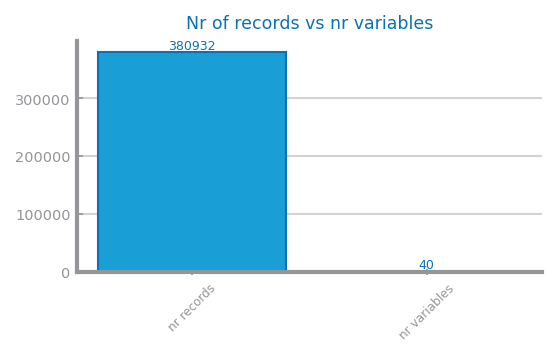

In [11]:
from matplotlib.pyplot import figure, savefig, show
from library.dslabs_functions import plot_bar_chart

figure(figsize=(4, 2))
values: dict[str, int] = {"nr records": data.shape[0], "nr variables": data.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title="Nr of records vs nr variables"
)
#savefig(f"images/{file_tag}_records_variables.png")
show()

{'numeric': ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI'], 'binary': ['Sex', 'PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos'], 'date': [], 'symbolic': ['State', 'GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'HadDiabetes', 'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory', 'TetanusLast10Tdap']}


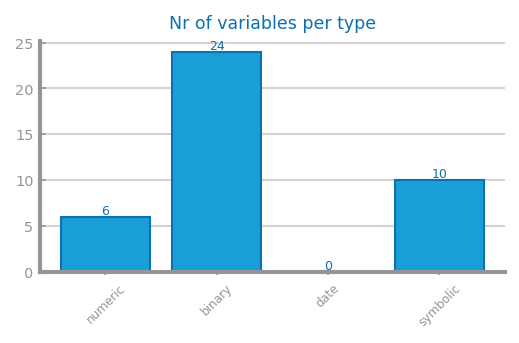

In [12]:
from library.dslabs_functions import get_variable_types
from matplotlib.pyplot import figure,savefig, show, subplots
from library.dslabs_functions import plot_bar_chart

variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
show()

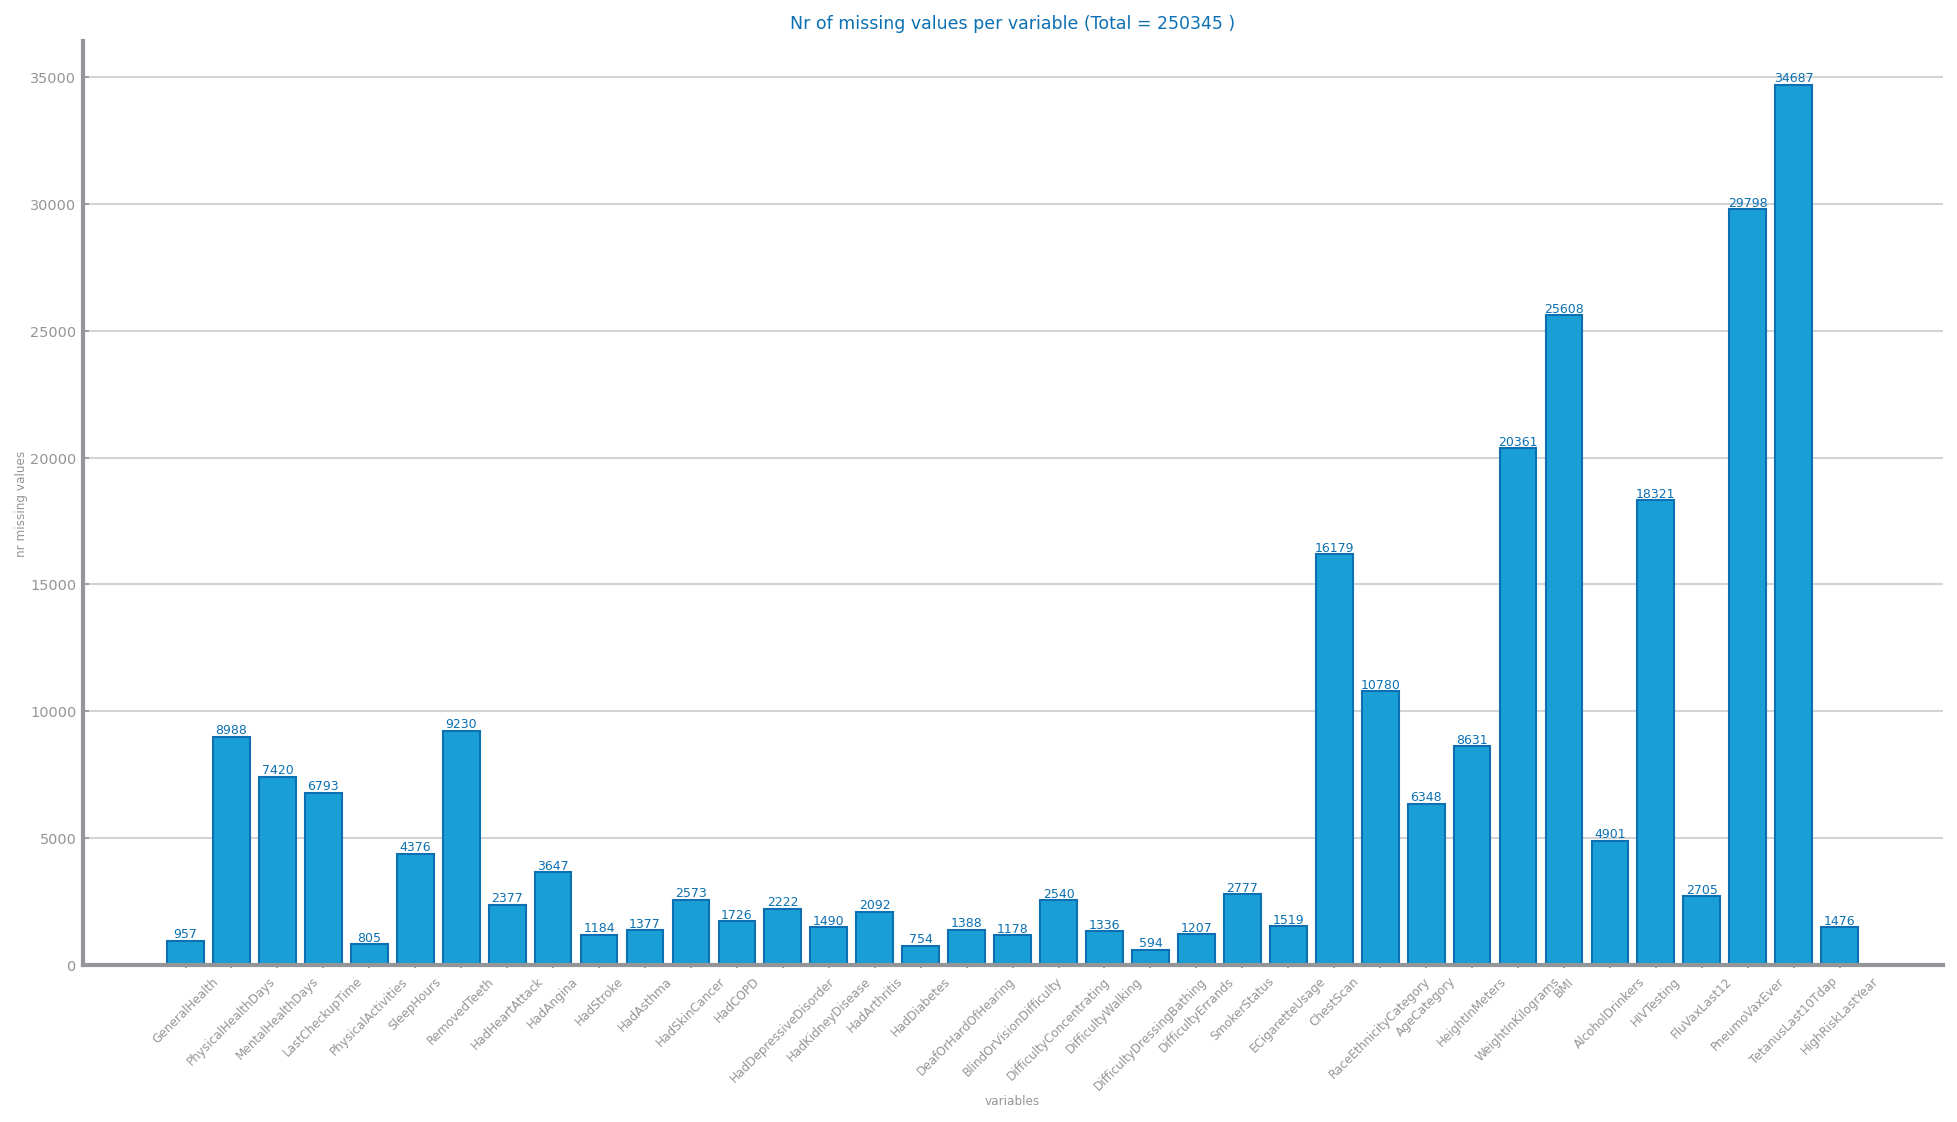

In [6]:
mv: dict[str, int] = {}
total = 0
for var in data.columns:
    nr: int = data[var].isna().sum()
    total += nr
    if nr > 0:
        mv[var] = nr

figure(figsize=(16, 8))
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable (Total = " + str(total) + " )",
    xlabel="variables",
    ylabel="nr missing values",
)
show()

Data Distribution:

In [ ]:
from pandas import Series
from library.dslabs_functions import plot_bar_chart
from library.dslabs_functions import define_grid, HEIGHT
from matplotlib.pyplot import figure,savefig, show, subplots

symbolic: list[str] = variable_types["symbolic"] + variable_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT + 20), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = data[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title="Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    show()
else:
    print("There are no symbolic variables.")

In [ ]:
from numpy import log
import numpy
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
from library.dslabs_functions import plot_multiline_chart, get_variable_types, define_grid, HEIGHT
from pandas import read_csv, DataFrame
from matplotlib.pyplot import savefig, show, subplots
from scipy.stats import skew, kurtosis

numeric: list[str] = variable_types["numeric"]
promising_distributions = []

def identify_promising_distributions(x_values: list) -> list:
    skewness = skew(x_values)
    kurtosis_ = kurtosis(x_values)
    if skewness > 1 and kurtosis_ > 3:
        promising_distributions.append("lognorm")
    if skewness < 1 and kurtosis_ < 3:
        promising_distributions.append("norm")
    if skewness > 1 and kurtosis_ < 3:
        promising_distributions.append("expon")
    return promising_distributions

def compute_known_distributions(x_values: list) -> dict:
    x = numpy.linspace(min(x_values), max(x_values), 100)  # 100 equally spaced points
    distributions = dict()
    if "norm" in promising_distributions:
        mean, sigma = norm.fit(x_values)
        distributions["Normal(%.1f,%.2f)" % (mean, sigma)] = norm.pdf(x, mean, sigma)
    if "expon" in promising_distributions:
        loc, scale = expon.fit(x_values)
        distributions["Exp(%.2f)" % (1 / scale)] = expon.pdf(x, loc, scale)
    if "lognorm" in promising_distributions:
        sigma, loc, scale = lognorm.fit(x_values)
        distributions["LogNor(%.1f,%.2f)" % (log(scale), sigma)] = lognorm.pdf(
            x, sigma, loc, scale
        )
    return x,distributions


def histogram_with_distributions(ax: Axes, series: Series, var: str):
    values: list = series.sort_values().to_list()
    ax.hist(values, 20, density=True)
    identify_promising_distributions(values)
    x, distributions = compute_known_distributions(values)
    print(distributions)
    for dist_name, pdf_values in distributions.items():
        ax.plot(x, pdf_values, label=dist_name)

    ax.legend(loc='upper right')  # Add a legend

    plot_multiline_chart(
        x,
        distributions,
        ax=ax,
        title="Best fit for %s" % var,
        xlabel=var,
        ylabel="",
    )


if [] != numeric:
    rows, cols = define_grid(len(numeric))
    fig,axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        histogram_with_distributions(axs[i, j], data[numeric[n]].dropna(), numeric[n])
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    #savefig(f"images/{file_tag}_histogram_numeric_distribution.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from matplotlib.pyplot import savefig, show
from library.dslabs_functions import get_variable_types

numeric: list[str] = variable_types["numeric"]
figure(figsize=(8, 12))
variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    data[numeric].boxplot(rot=45)
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from library.dslabs_functions import define_grid, HEIGHT

if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(data[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    #savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from library.dslabs_functions import plot_multibar_chart

NR_STDEV: int = 2
IQR_FACTOR: float = 1.5

def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(data, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    #savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from library.dslabs_functions import set_chart_labels

if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(data[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    #savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
from pandas import Series
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from library.dslabs_functions import define_grid, HEIGHT

target = "CovidPos"

values: Series = data[target].value_counts()

figure(figsize=(4, 2))
plot_bar_chart(
    values.index.to_list(),
    values.to_list(),
    title=f"Target distribution (target={target})",
)
#savefig(f"images/{file_tag}_class_distribution.png")
show()

Data Sparcity:

In [ ]:
from library.dslabs_functions import HEIGHT, plot_multi_scatters_chart

data = data.dropna()
vars: list = data.columns.to_list()
if [] != vars:
    target = "stroke"
    n: int = len(vars) - 1
    fig: Figure
    axs: ndarray
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)
    for i in range(len(vars)):
        var1: str = vars[i]
        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            plot_multi_scatters_chart(data, var1, var2, ax=axs[i, j - 1])
    #savefig(f"images/{file_tag}_sparsity_study.png")
    show()
else:
    print("Sparsity class: there are no variables.")

In [ ]:
if [] != vars:
    target = "stroke"

    n: int = len(vars) - 1
    fig, axs = subplots(n, n, figsize=(n * HEIGHT, n * HEIGHT), squeeze=False)
    for i in range(len(vars)):
        var1: str = vars[i]
        for j in range(i + 1, len(vars)):
            var2: str = vars[j]
            plot_multi_scatters_chart(data, var1, var2, target, ax=axs[i, j - 1])
    #savefig(f"images/{file_tag}_sparsity_per_class_study.png")
    show()
else:
    print("Sparsity per class: there are no variables.")

In [ ]:
from seaborn import heatmap
from library.dslabs_functions import get_variable_types

variables_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = data[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
#savefig(f"images/{file_tag}_correlation_analysis.png")
show()

Data Granularity:

In [17]:
# State
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Define the latitude and longitude for each state
state_coordinates = {
    'Alabama': [32.318231, -86.902298],
    'Alaska': [63.588753, -154.493062],
    'Arizona': [34.048928, -111.093731],
    'Arkansas': [35.20105, -91.831833],
    'California': [36.778261, -119.417932],
    'Colorado': [39.550051, -105.782067],
    'Connecticut': [41.603221, -73.087749],
    'Delaware': [38.910832, -75.52767],
    'District of Columbia': [38.895, -77.03667],
    'Florida': [27.664827, -81.515754],
    'Georgia': [32.157435, -82.907123],
    'Hawaii': [19.898682, -155.665857],
    'Idaho': [44.068202, -114.742041],
    'Illinois': [40.633125, -89.398528],
    'Indiana': [40.551217, -85.602364],
    'Iowa': [41.878003, -93.097702],
    'Kansas': [39.011902, -98.484246],
    'Kentucky': [37.839333, -84.270018],
    'Louisiana': [31.244823, -92.145024],
    'Maine': [45.253783, -69.445469],
    'Maryland': [39.045755, -76.641271],
    'Massachusetts': [42.407211, -71.382437],
    'Michigan': [44.314844, -85.602364],
    'Minnesota': [46.729553, -94.6859],
    'Mississippi': [32.354668, -89.398528],
    'Missouri': [37.964253, -91.831833],
    'Montana': [46.879682, -110.362566],
    'Nebraska': [41.492537, -99.901813],
    'Nevada': [38.80261, -116.419389],
    'New Hampshire': [43.193852, -71.572395],
    'New Jersey': [40.058324, -74.405661],
    'New Mexico': [34.97273, -105.032363],
    'New York': [43.299428, -74.217933],
    'North Carolina': [35.759573, -79.0193],
    'North Dakota': [47.551493, -101.002012],
    'Ohio': [40.417287, -82.907123],
    'Oklahoma': [35.007752, -97.092877],
    'Oregon': [43.804133, -120.554201],
    'Pennsylvania': [41.203322, -77.194525],
    'Rhode Island': [41.580095, -71.477429],
    'South Carolina': [33.836081, -81.163725],
    'South Dakota': [43.969515, -99.901813],
    'Tennessee': [35.517491, -86.580447],
    'Texas': [31.968599, -99.901813],
    'Utah': [39.32098, -111.093731],
    'Vermont': [44.558803, -72.577841],
    'Virginia': [37.431573, -78.656894],
    'Washington': [47.751074, -120.740139],
    'West Virginia': [38.597626, -80.454903],
    'Wisconsin': [43.78444, -88.787868],
    'Wyoming': [43.075968, -107.290284],
    'Guam': [13.444304, 144.793732],
    'Puerto Rico': [18.220833, -66.590149],
    'Virgin Islands': [18.3434, -64.8672]
}

# Convert the dictionary into a DataFrame
df_state = pd.DataFrame.from_dict(state_coordinates, orient='index', columns=['latitude', 'longitude'])
# Convert the dictionary into a DataFrame
df_state = pd.DataFrame.from_dict(state_coordinates, orient='index', columns=['latitude', 'longitude'])

# Calculate the median latitude and longitude
median_latitude = df_state['latitude'].median()
median_longitude = df_state['longitude'].median()

# Create a new column 'quadrant' based on the median latitude and longitude
df_state['Quadrant'] = np.select(
    [
        (df_state['latitude'] > median_latitude) & (df_state['longitude'] > median_longitude), 
        (df_state['latitude'] <= median_latitude) & (df_state['longitude'] > median_longitude),
        (df_state['latitude'] > median_latitude) & (df_state['longitude'] <= median_longitude),
        (df_state['latitude'] <= median_latitude) & (df_state['longitude'] <= median_longitude)
    ], 
    [
        'Q1', 
        'Q2',
        'Q3',
        'Q4'
    ], 
    default='Unknown'
)

# Assuming df is your DataFrame and it has a column 'quadrant'
df_state['Quadrant'] = df_state['Quadrant'].map({'Q1': 0, 'Q2': 1, 'Q3': 2, 'Q4': 3})
df = pd.merge(data, df_state, left_on='State', right_index=True)

In [ ]:
from numpy import ndarray

def analyse_property_granularity(
    data: DataFrame, property: str, vars: list[str]
) -> ndarray:
    cols: int = len(vars)
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    fig.suptitle(f"Granularity study for {property}")
    for i in range(cols):
        counts: Series[int] = data[vars[i]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[0, i],
            title=vars[i],
            xlabel=vars[i],
            ylabel="nr records",
            percentage=False,
        )
    return axs
analyse_property_granularity(df, "State", ["State","Quadrant"])
show()